In [1]:
import pandas as pd
from supersmoother import SuperSmoother
import pickle
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import numpy as np
from PS5 import load_channel_data, normal_binify, my_peaks, linear_guass
from scipy.optimize import curve_fit
import seaborn as sns
from scipy.interpolate import RegularGridInterpolator

sns.set(style="whitegrid", context="talk")

In [2]:
channel_data = load_channel_data()
values1 = channel_data.loc[1, "values"]
times1 = channel_data.loc[1, "time"]
times1 -= times1.min()
t1sort_idx = times1.argsort()
times1 = times1[t1sort_idx]
values1 = values1[t1sort_idx]

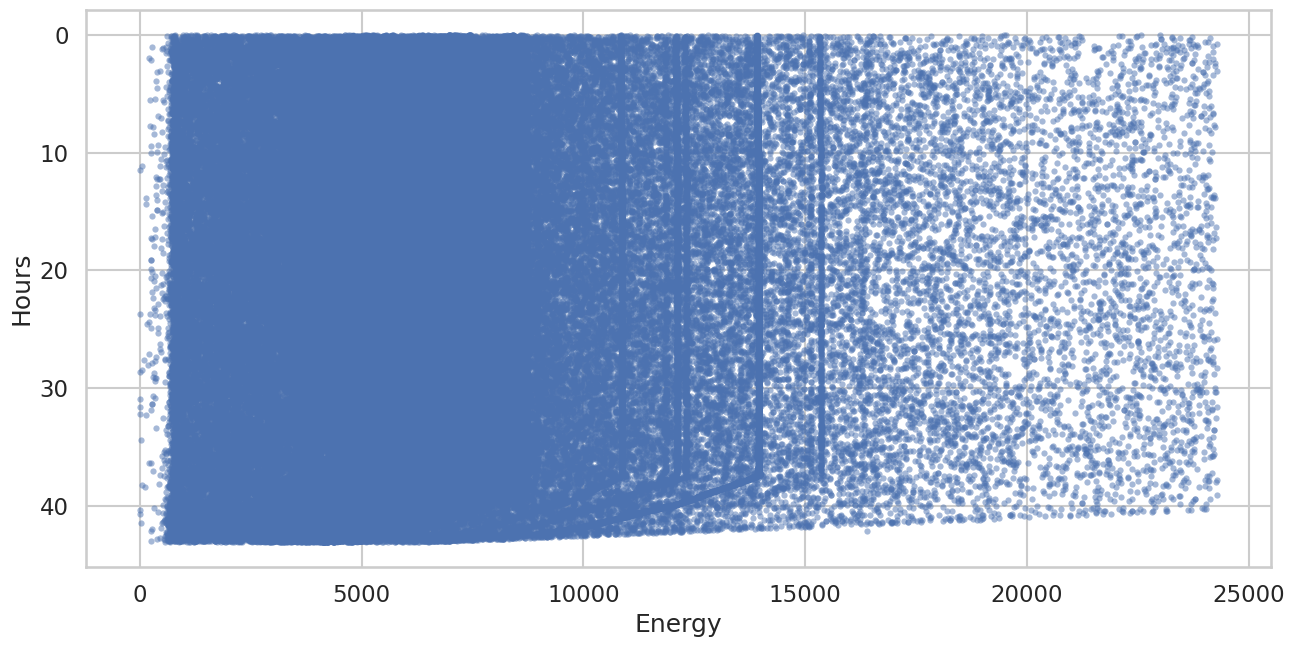

In [3]:
ax = sns.scatterplot(x=values1, y=times1 / 60 / 60, marker=".", linewidth=0, alpha=0.5)
ax.set_xlabel("Energy")
ax.set_ylabel("Hours")
ax.invert_yaxis()
ax.figure.set_size_inches(13.32, 6.81)
ax.figure.tight_layout()

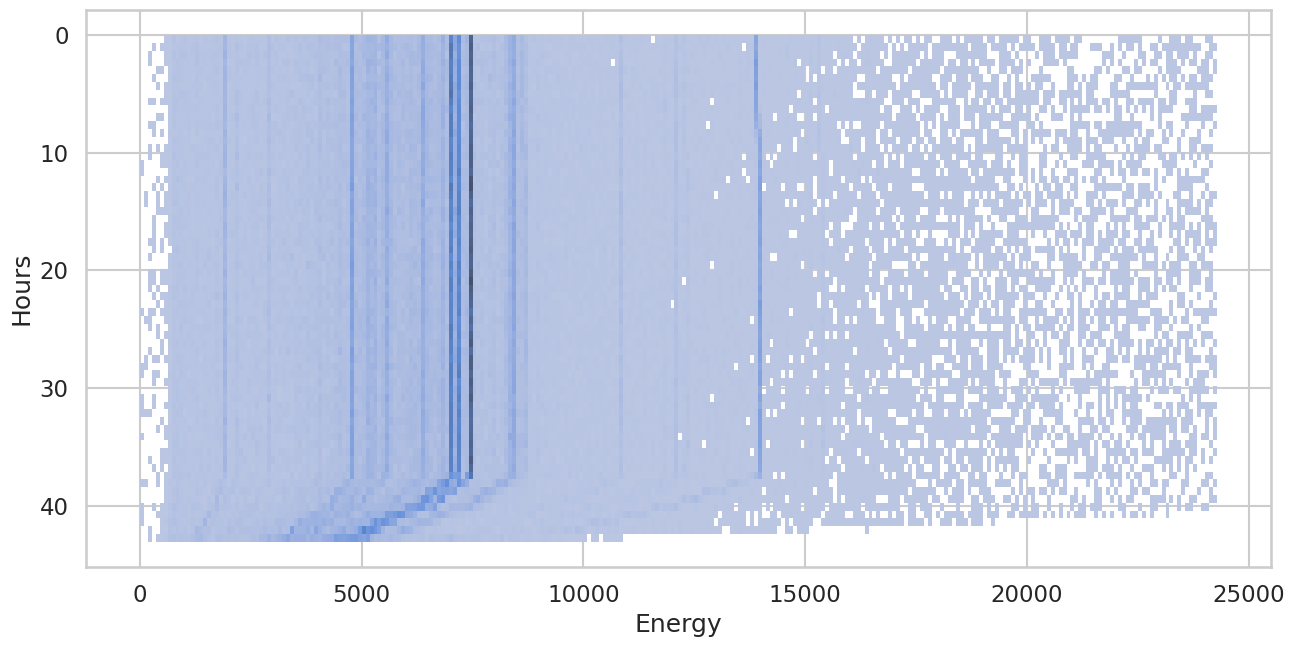

In [4]:
ax = sns.histplot(x=values1, y=times1 / 60 / 60)
ax.set_xlabel("Energy")
ax.set_ylabel("Hours")
ax.invert_yaxis()
ax.figure.set_size_inches(13.32, 6.81)
ax.figure.tight_layout()

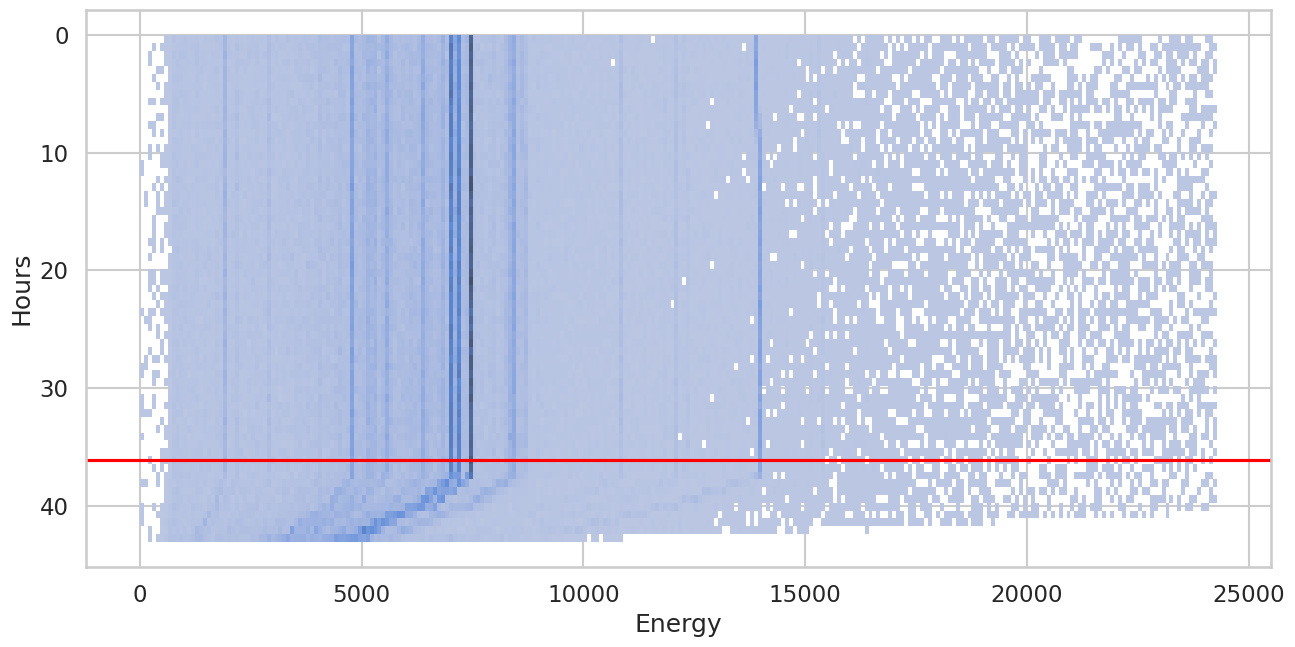

In [5]:
trim_value = 130_000
ax = sns.histplot(x=values1, y=times1 / 60 / 60)
ax.set_xlabel("Energy")
ax.set_ylabel("Hours")
ax.invert_yaxis()
ax.axhline(trim_value / 60 / 60, color="red")
ax.figure.set_size_inches(13.32, 6.81)
ax.figure.tight_layout()

before_falloff_mask = times1 < trim_value
times1 = times1[before_falloff_mask]
values1 = values1[before_falloff_mask]

In [6]:
try:
    with open("peaks1.pickle", "rb") as f:
        peaks1, hist, bins = pickle.load(f)
except FileNotFoundError:
    hist, bins = normal_binify(values1)
    peaks1, windows = my_peaks(hist, bins, n=0)
    peaks1 = pd.DataFrame(
        peaks1, columns=["center", "height", "std", "offset", "slope"]
    )
    peaks1["window_left"] = bins[np.array(windows)[:, 0]]
    peaks1["window_right"] = bins[np.array(windows)[:, 1]]
    peaks1 = peaks1[peaks1["slope"].abs() < 2e-5].sort_values("height")
    with open("peaks1.pickle", "wb") as f:
        pickle.dump((peaks1, hist, bins), f)

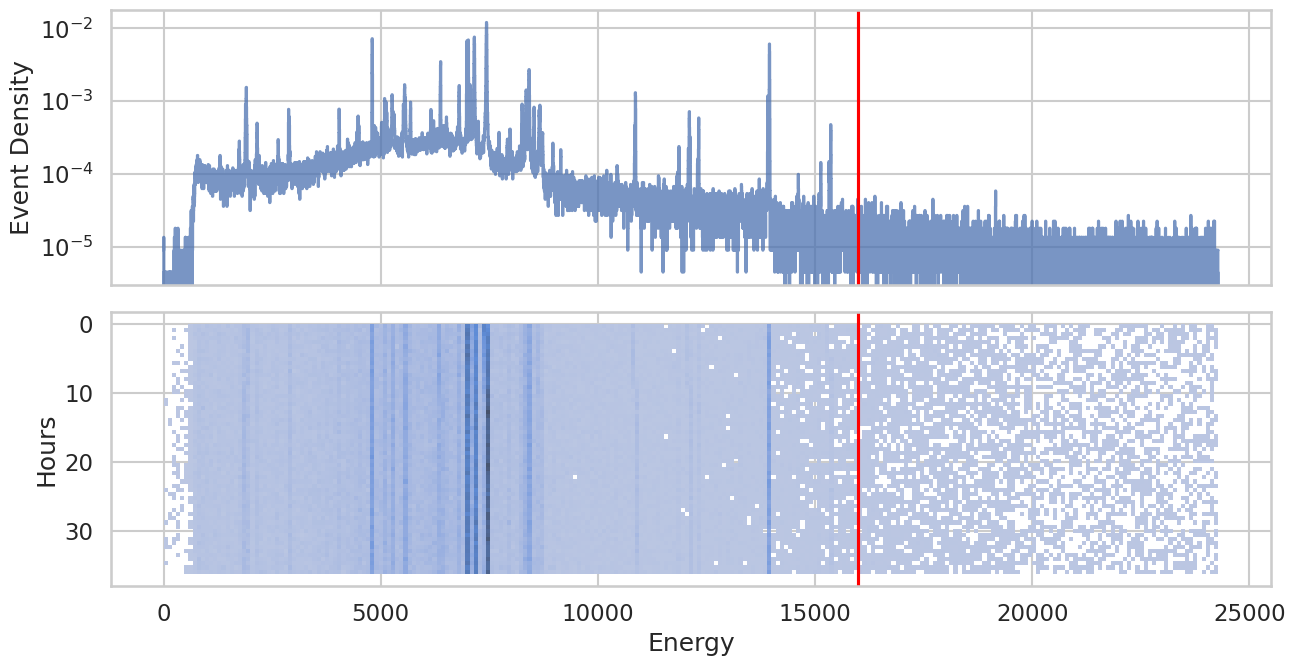

In [7]:
fig, (ax0, ax) = plt.subplots(nrows=2, ncols=1, sharex=True)
sns.histplot(x=values1, y=times1 / 60 / 60, ax=ax)
ax.set_xlabel("Energy")
ax.set_ylabel("Hours")
ax.invert_yaxis()

ax0.step(bins, hist, where="mid", alpha=0.75)
ax0.set_ylabel("Event Density")
ax0.set_yscale("log")

e_end = 16000
ax0.axvline(e_end, color="red")
ax.axvline(e_end, color="red")

fig.set_size_inches(13.32, 7)
fig.tight_layout()

In [8]:
def plotpeak(peak, ax=None, basecolor="grey", peakcolor="orange", bound=None, num=50):
    if len(peak) == 5:
        [center, height, std, offset, slope] = peak
    else:
        [center, height, std, offset, slope] = peak[
            ["center", "height", "std", "offset", "slope"]
        ]

    if bound is None:
        try:
            left, right = peak[["window_left", "window_right"]]
        except KeyError:
            left = center - 2 * std
            right = center + 2 * std
    else:
        try:
            left, right = bound
        except TypeError:
            left = center - bound * std
            right = center + bound * std

    ax = ax or plt.gca()

    xs = np.linspace(left, right, num=50)
    baseline = (xs - center) * slope + offset
    curve = linear_guass(xs, center, height, std, offset, slope)
    ax.plot(xs, baseline, color=basecolor)
    ax.plot(xs, curve, color=peakcolor)

In [20]:
default_peak_color = sns.color_palette("deep")[1]


def axis_pair_plot(ax0, ax1, hist, bins, times, values, emin, emax):
    display_window = (emin < values) & (values < emax)
    times = times[display_window]
    values = values[display_window]
    ax0.step(bins, hist, where="mid")
    sns.histplot(x=values, y=times / 60 / 60, ax=ax1)
    ax1.invert_yaxis()
    ax0.set_xlim(emin, emax)


def make_stack_peaks_plot(
    show_peaks, smooth=False, logy=False, color=default_peak_color, dedrift=False, title=False, ylim=None, show_dedrift=False
):
    fig, axes = plt.subplots(nrows=2, ncols=len(show_peaks), sharex="col", sharey="row")

    if smooth:
        drift_info = {}

    for (ax0, ax1), (colid, peak) in zip(axes.T, show_peaks.iterrows()):
        if colid == 0:
            ax0.set_ylabel("Event Density")
        if colid == 0:
            ax1.set_ylabel("Hours")
        ax1.set_xticks([peak["center"]])
        if title:
            ax0.set_title(' ')
        if ylim:
            ax0.set_ylim(0, ylim)
        
        if show_dedrift:
            arrows = 5
            for i in range(1, arrows + 1):
                t = times1.max() * (i / arrows - .5/arrows)
                ax1.arrow(peak['center'], t/60/60, -dedrift([peak['center'], t])[0], 0, color=sns.color_palette('deep')[6], zorder=2.5, head_width=3/5, head_length=30/5)
        elif smooth:
            model = SuperSmoother()
            fit_over_mask = (peak["center"] - smooth < values1) & (
                values1 < peak["center"] + smooth
            )
            model.fit(times1[fit_over_mask], values1[fit_over_mask])
            start_energy = model.predict(0)
            drift = model.predict(times1) - start_energy
            drift_info[peak['center']] = drift
            if dedrift:
                if callable(dedrift):
                    drift = dedrift(np.vstack([values1, times1]).T)
                adjusted_values = values1 - drift
                ahist, abins = normal_binify(adjusted_values)
                refit_left = peak["center"] - peak['std'] * 5 - drift.max()
                refit_right = peak["center"] + peak['std'] * 5 - drift.min()
                in_refit_mask = (refit_left < abins) & (abins < refit_right)
                [newpeak], _ = my_peaks(ahist[in_refit_mask], abins[in_refit_mask], n=1)
                xdata = abins[in_refit_mask]
                ydata = ahist[in_refit_mask]
                newpeak = pd.Series(newpeak, index=["center", "height", "std", "offset", "slope"])
                axis_pair_plot(
                    ax0,
                    ax1,
                    ahist,
                    abins,
                    times1,
                    adjusted_values,
                    peak['center'] - 100,
                    peak['center'] + 100,
                )
                plotpeak(newpeak, ax=ax0, peakcolor=color, bound=(refit_left, refit_right))
                ax1.fill_betweenx(
                    [times1.min(), times1.max() / 60 / 60],
                    refit_left,
                    refit_right,
                    color="grey",
                    alpha=0.3,
                )
                
                if title:
                    ax0.set_title(' ')
                else:
                    old_snr = peak['height'] / peak['std']
                    new_snr = newpeak['height'] / newpeak['std']
                    ax0.set_title(f'SNR: {(new_snr - old_snr) / old_snr * 100:.0f}% better')
                continue
            else:
                ts = np.linspace(times1.min(), times1.max())
                smooth_energies = model.predict(ts)
                ax1.plot(smooth_energies, ts / 60 / 60, color="black")
                ax1.scatter(
                    model.predict(0),
                    0,
                    color=sns.color_palette("deep")[4],
                    marker=".",
                    zorder=2.5,
                )
                ax1.fill_betweenx(
                    [times1.min(), times1.max() / 60 / 60],
                    peak["center"] - smooth,
                    peak["center"] + smooth,
                    color="grey",
                    alpha=0.3,
                )

        axis_pair_plot(
            ax0,
            ax1,
            hist,
            bins,
            times1,
            values1,
            peak["center"] - 100,
            peak["center"] + 100,
        )
        plotpeak(peak, ax=ax0, peakcolor=color)

    if logy:
        axes[0, 0].set_yscale("log")

    fig.supxlabel("Energy")
    fig.set_size_inches(13.32, 6.81)
    fig.tight_layout()
    if smooth:
        return drift_info

# make_stack_peaks_plot(peaks1.loc[[1651, 1659]]);

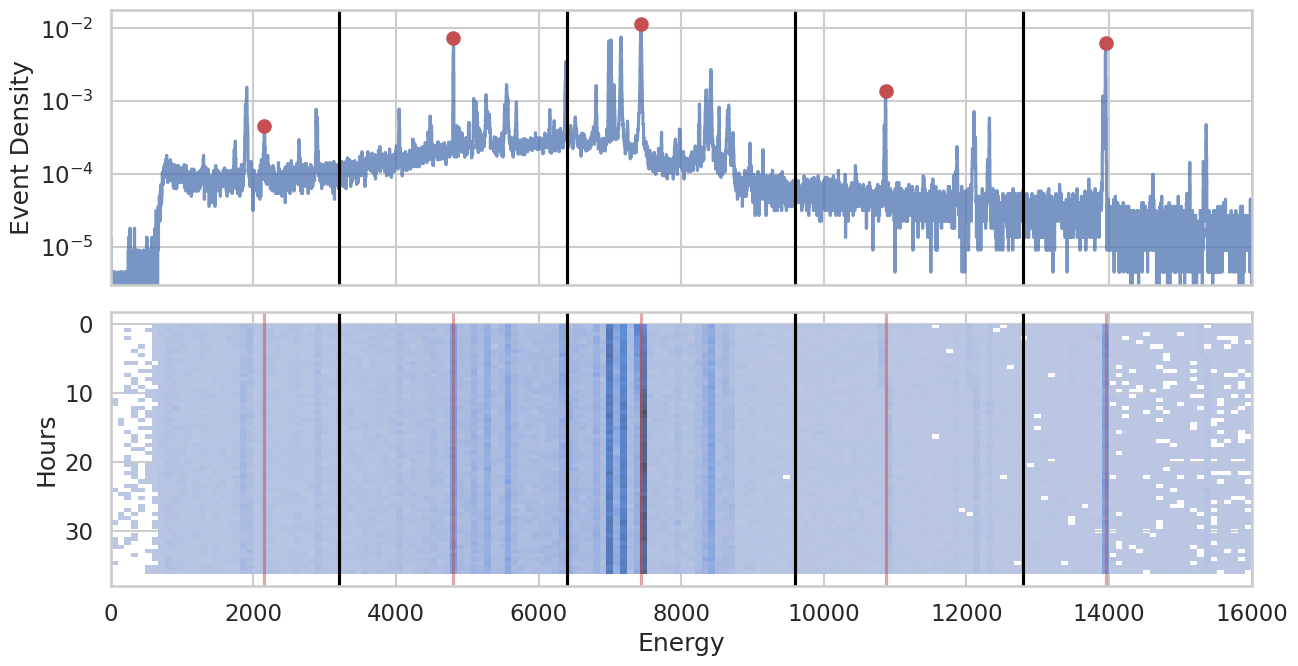

In [10]:
range_width = int(e_end / 5)
range_starts = range(0, e_end, range_width)
# (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
calib_peak_color = sns.color_palette("deep")[3]

fig, (ax0, ax) = plt.subplots(nrows=2, ncols=1, sharex=True)
sns.histplot(x=values1, y=times1 / 60 / 60, ax=ax)
ax.set_xlabel("Energy")
ax.set_ylabel("Hours")
ax.invert_yaxis()

ax0.step(bins, hist, where="mid", alpha=0.75)
ax0.set_ylabel("Event Density")
ax0.set_yscale("log")

ax0.set_xlim(0, e_end)

selected_peaks = []
for start in range_starts:
    index = -3 if start == 0 else -1
    selected_peaks.append(
        peaks1.query("(@start < center) & (center < @start + @range_width)")
        .sort_values("height")
        .iloc[index]
    )
    if start == 0:
        continue
    ax0.axvline(start, color="black")
    ax.axvline(start, color="black")
selected_peaks = pd.DataFrame(selected_peaks)
ax0.scatter(
    selected_peaks["center"],
    selected_peaks.eval("height + offset"),
    color=calib_peak_color,
    zorder=2.5,
)
selected_peaks["center"].apply(ax.axvline, color=calib_peak_color, alpha=0.5)

fig.set_size_inches(13.32, 7)
fig.tight_layout()

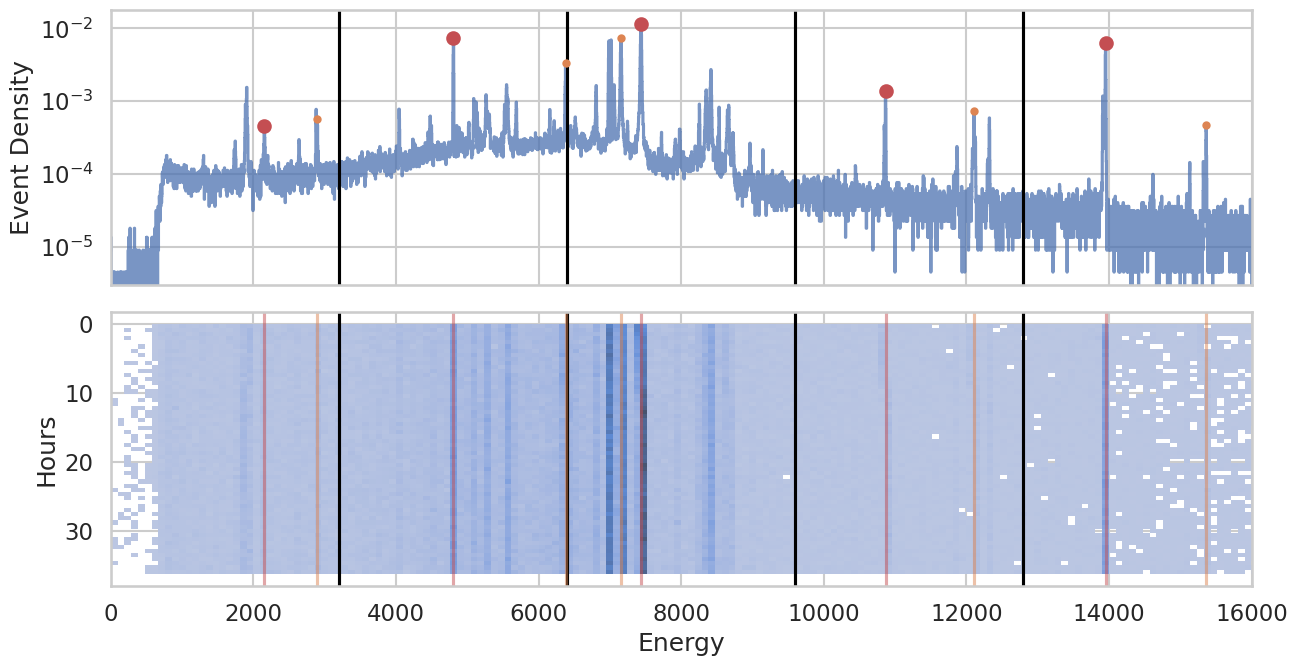

In [11]:
range_width = int(e_end / 5)
range_starts = range(0, e_end, range_width)
# (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
test_peak_color = sns.color_palette("deep")[1]

fig, (ax0, ax) = plt.subplots(nrows=2, ncols=1, sharex=True)
sns.histplot(x=values1, y=times1 / 60 / 60, ax=ax)
ax.set_xlabel("Energy")
ax.set_ylabel("Hours")
ax.invert_yaxis()

ax0.step(bins, hist, where="mid", alpha=0.75)
ax0.set_ylabel("Event Density")
ax0.set_yscale("log")

ax0.set_xlim(0, e_end)

test_peaks = []
for start in range_starts:
    index = -4 if start == 0 else -2
    test_peaks.append(
        peaks1.query("(@start < center) & (center < @start + @range_width)")
        .sort_values("height")
        .iloc[index]
    )
    if start == 0:
        continue
    ax0.axvline(start, color="black")
    ax.axvline(start, color="black")
test_peaks = pd.DataFrame(test_peaks)
ax0.scatter(
    test_peaks["center"],
    test_peaks.eval("height + offset"),
    color=test_peak_color,
    zorder=2.5,
    marker='.'
)
test_peaks["center"].apply(ax.axvline, color=test_peak_color, alpha=0.5)
ax0.scatter(
    selected_peaks["center"],
    selected_peaks.eval("height + offset"),
    color=calib_peak_color,
    zorder=2.5,
)
selected_peaks["center"].apply(ax.axvline, color=calib_peak_color, alpha=0.5)

fig.set_size_inches(13.32, 7)
fig.tight_layout()

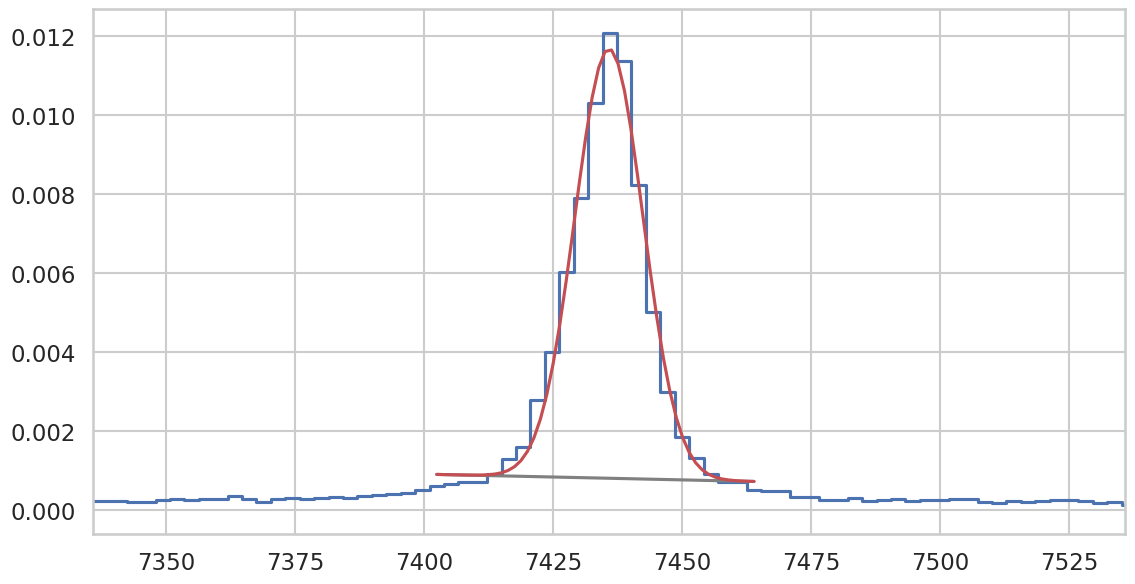

In [31]:
plt.step(bins, hist, where='mid')
show = selected_peaks.iloc[2]
plotpeak(show, peakcolor=calib_peak_color)
plt.xlim(show['center'] - 100, show['center'] + 100)
plt.gca().figure.set_size_inches(13.32, 6.81)

In [ ]:
drift_info = make_stack_peaks_plot(selected_peaks, color=calib_peak_color, smooth=60, dedrift=True, ylim=0.015)

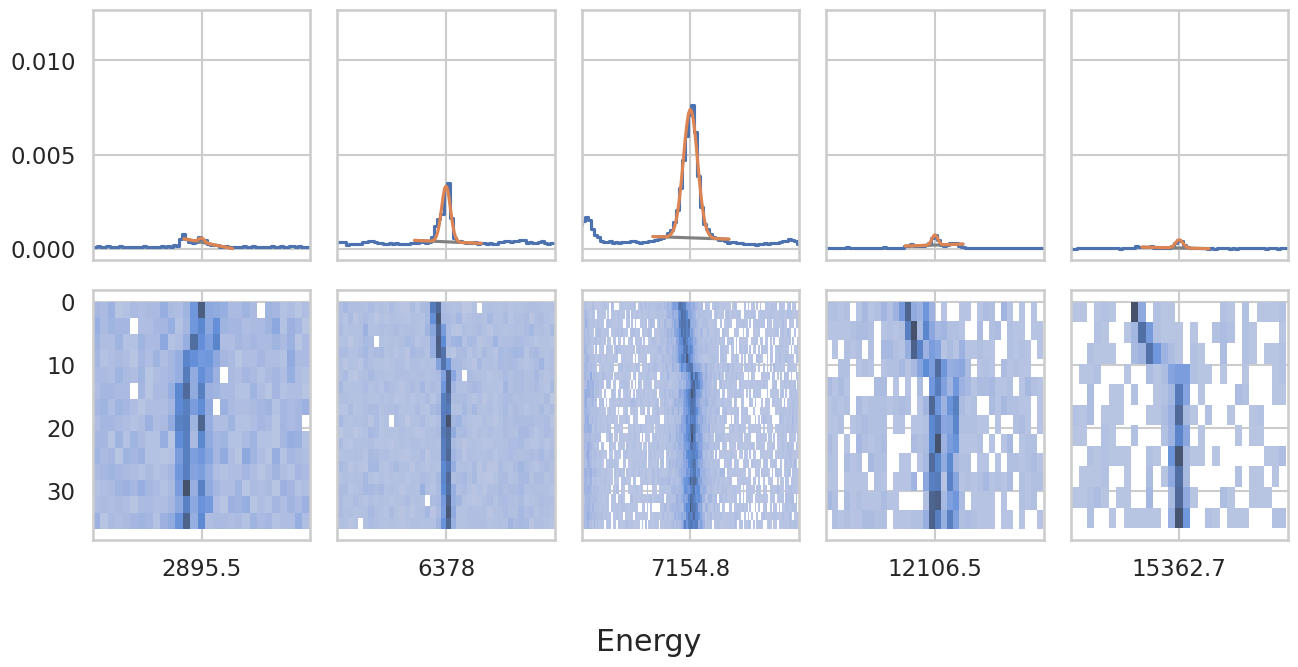

In [13]:
make_stack_peaks_plot(test_peaks)

In [14]:
es = np.array(list(drift_info.keys()))
drift_grid = np.array(list(drift_info.values()))
interp = RegularGridInterpolator(
    (es, times1), drift_grid, bounds_error=False, fill_value=None
)

count = 100
eshow = np.linspace(values1.min(), e_end, count)
tshow = np.linspace(times1.min(), times1.max(), count)
eshow, tshow = np.meshgrid(eshow, tshow)
interp_drifts = interp(np.vstack([eshow.flatten(), tshow.flatten()]).T).reshape(
    (count, count)
)

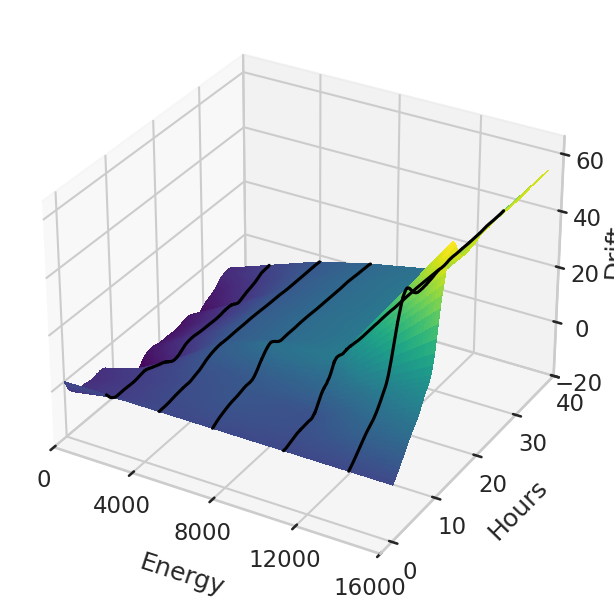

In [15]:
import operator

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d")

ax.plot_surface(
    eshow,
    tshow / 60 / 60,
    interp_drifts,
    ccount=count,
    rcount=count,
    cmap="viridis",
    linewidth=0,
    antialiased=False,
)
for center, drifts in sorted(drift_info.items(), key=operator.itemgetter(0)):
    ax.plot(times1 / 60 / 60, drifts, zs=center, zdir="x", color="black")
ax.set_ylabel("\nHours")
ax.set_xlabel("\n\nEnergy")
ax.set_zlabel('Drift')
ax.set_xlim(0, e_end)
ax.set_xticks(range(0, 16001, 4000))
ax.set_yticks(range(0, 41, 10))

fig.set_size_inches(13.32, 6.81)
fig.tight_layout(pad=2)
fig.savefig("/home/finally/Desktop/tmp.png")

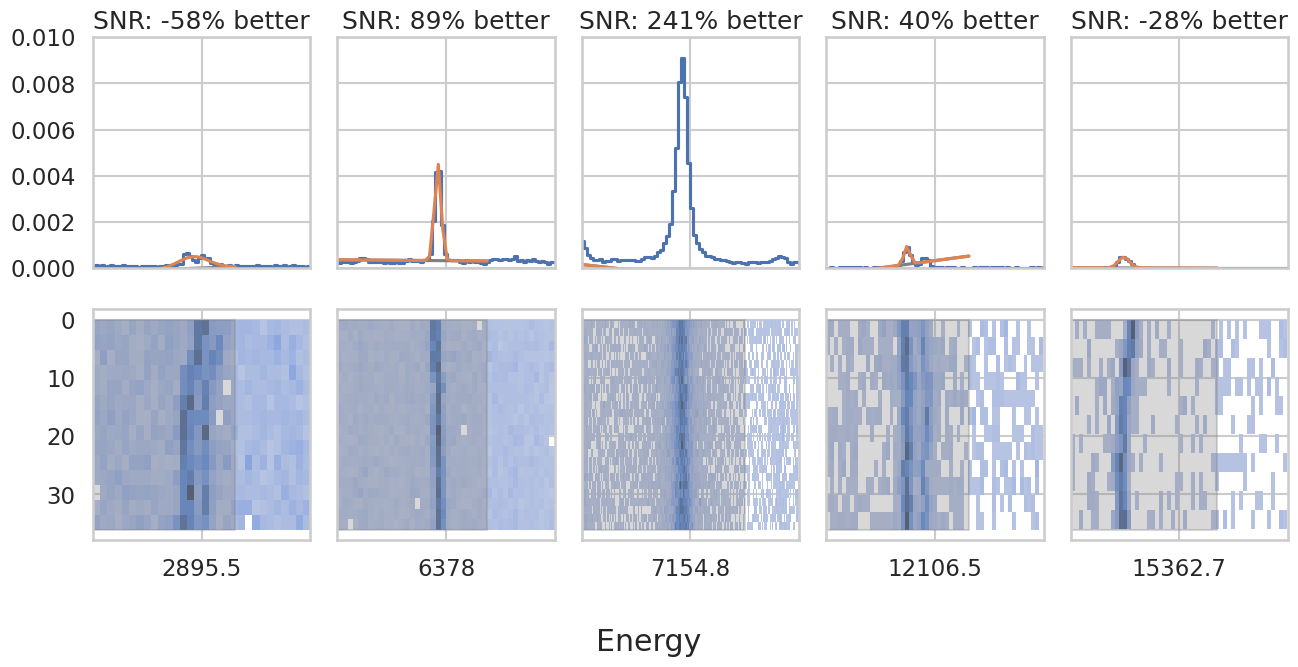

In [16]:
make_stack_peaks_plot(test_peaks, smooth=60, title=True, ylim=0.01, dedrift=interp);

In [17]:
adjusted_values = values1 - interp(np.vstack([values1, times1]).T)
ahist, abins = normal_binify(adjusted_values)
try:
    with open('adjpeask1.pkl', 'rb') as f:
        adjpeask1 = pickle.load(f)
except FileNotFoundError:
    adjpeask1, _ = my_peaks(ahist, abins, n=0)
    adjpeask1 = pd.DataFrame(adjpeask1, columns=['center', 'height', 'std', 'offset', 'slope'])
    with open('adjpeaks1.pkl', 'wb') as f:
        pickle.dump(adjpeask1, f)

/home/finally/Smoothing/PS5.py:84: RuntimeWarning: invalid value encountered in scalar divide
  slope_guess = (hist[right] - hist[left]) / (2 * sigma_guess)


In [18]:
peaks1.eval('snr = height / std', inplace=True)
adjpeask1.eval('snr = height / std', inplace=True)
old_snr_mean = np.mean(peaks1.sort_values('height')[-50:]['snr'])
new_snr_mean = np.mean(adjpeask1.sort_values('height')[-50:]['snr'])
(new_snr_mean - old_snr_mean) / old_snr_mean * 100

np.float64(73.8326439701059)

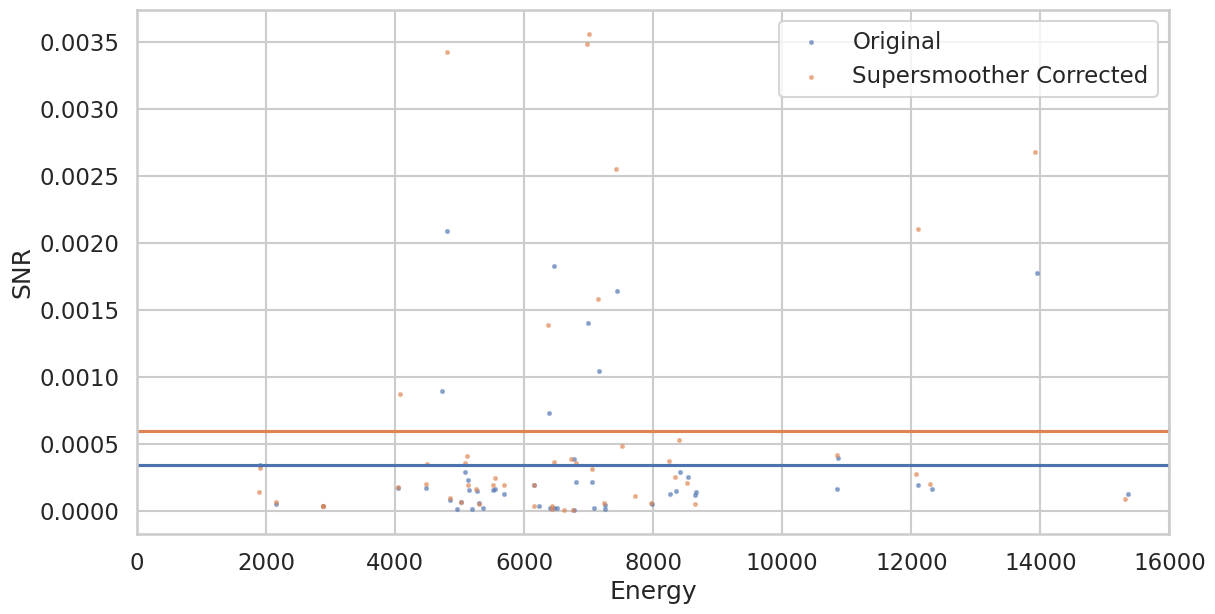

In [26]:
ax = peaks1.sort_values('height')[-50:].plot.scatter(x='center', y='snr', alpha=.5, marker='.', label='Original')
adjpeask1.sort_values('height')[-50:].plot.scatter(x='center', y='snr', ax=ax, color=test_peak_color, alpha=.5, marker='.', label='Supersmoother Corrected', xlabel='Energy', ylabel='SNR')
ax.axhline(old_snr_mean)
ax.axhline(new_snr_mean, color=test_peak_color)
ax.figure.set_size_inches(13.32, 6.81)
ax.set_xlim(0, 16000)
plt.legend()